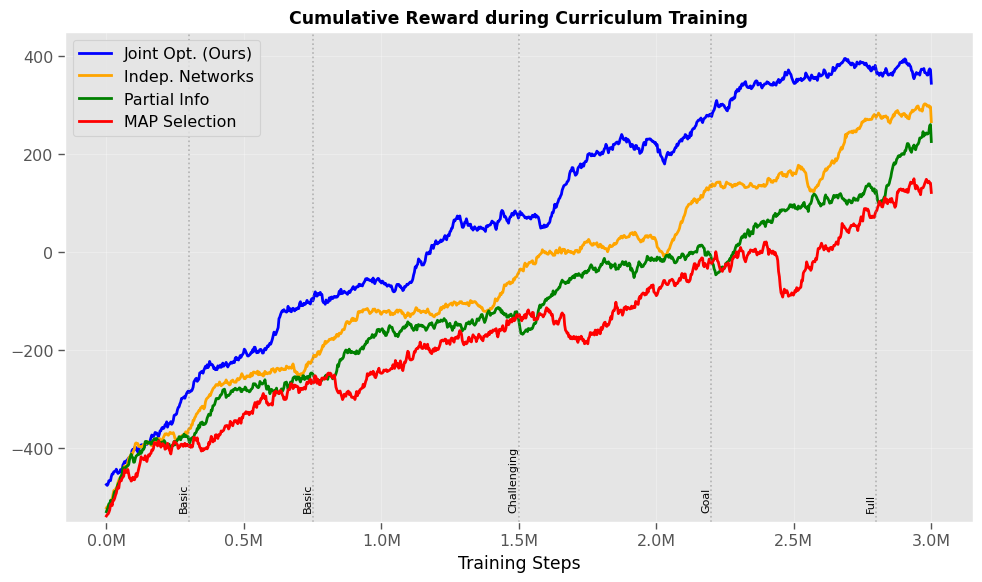

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator

# Set the style
plt.style.use('ggplot')
sns.set_context("paper", font_scale=1.3)

# Create training steps (0 to 3 million)
steps = np.linspace(0, 3000000, 1000)

# Set random seed for reproducibility
np.random.seed(42)

# Define curriculum stages
curriculum_stages = [
    {"name": "Basic goal-directed", "position": 300000, "color": "gray"},
    {"name": "Basic collision avoidance", "position": 750000, "color": "gray"},
    {"name": "Challenging obstacles", "position": 1500000, "color": "gray"},
    {"name": "Goal ambiguity (2-3 targets)", "position": 2200000, "color": "gray"},
    {"name": "Full complexity", "position": 2800000, "color": "gray"}
]

# Define models for the ablation study based on the paper
models = {
    'Joint Opt. (Ours)': {
        'color': 'blue', 
        'smoothness': 0.92, 
        'noise': 0.06, 
        'plateau_factor': 1.0,
        'curriculum_speedup': 1.4,
        'drop_size': 0.10
    },
    'Indep. Networks': {
        'color': 'orange', 
        'smoothness': 0.9, 
        'noise': 0.04, 
        'plateau_factor': 0.8,
        'curriculum_speedup': 1.1,
        'drop_size': 0.15
    },
    'Partial Info': {
        'color': 'green', 
        'smoothness': 0.88, 
        'noise': 0.045, 
        'plateau_factor': 0.7,
        'curriculum_speedup': 1.0,
        'drop_size': 0.18
    },
    'MAP Selection': {
        'color': 'red', 
        'smoothness': 0.85, 
        'noise': 0.05, 
        'plateau_factor': 0.0,
        'curriculum_speedup': 0.9,
        'drop_size': 0.25
    }
}

# Function to generate learning curves with curriculum stages and transition drops
def generate_curriculum_learning_curve(base_level, final_level, noise_scale, smoothness, num_points, 
                                      curriculum_stages, curriculum_speedup=1.0, plateau_factor=1.0, drop_size=0.15):
    trend = np.zeros(num_points)
    
    # Calculate indices where stages occur, factoring in any speedup
    stage_indices = [0]
    for stage in curriculum_stages:
        idx = min(int(stage["position"] * num_points / 3000000 / curriculum_speedup), num_points - 1)
        stage_indices.append(idx)
    if stage_indices[-1] < num_points - 1:
        stage_indices.append(num_points - 1)
    stage_indices = sorted(list(set(stage_indices)))
    
    # Relative improvement from base_level to final_level
    improvements = np.linspace(0, 1.0, len(stage_indices))
    prev_end_value = base_level
    
    for i in range(len(stage_indices) - 1):
        start_idx = stage_indices[i]
        end_idx   = stage_indices[i+1]
        if start_idx == end_idx:
            continue
        
        segment_length = end_idx - start_idx
        segment_target = base_level + improvements[i+1] * (final_level - base_level)
        
        if i > 0:
            progress_so_far = prev_end_value - base_level
            drop_amount = progress_so_far * drop_size
            segment_start = prev_end_value - drop_amount
        else:
            segment_start = base_level
        
        segment_x = np.linspace(0, 1, segment_length)
        
        # Add a plateau if the segment is long enough
        if plateau_factor > 0 and segment_length > 10:
            plateau_idx = min(int(segment_length * 0.6), segment_length - 1)
            pre_curve = segment_start + (segment_target - segment_start) * 0.9 * (
                1 - np.exp(-4 * segment_x[:plateau_idx] / max(segment_x[:plateau_idx]))
            )
            remaining_x = segment_x[plateau_idx:] - segment_x[plateau_idx]
            
            if len(remaining_x) > 0:
                max_remaining = max(remaining_x)
                post_curve = segment_start + (segment_target - segment_start) * (
                    0.9 + 0.1 * (remaining_x / max_remaining)
                )
                segment_curve = np.zeros(segment_length)
                segment_curve[:plateau_idx] = pre_curve
                segment_curve[plateau_idx:] = post_curve
            else:
                segment_curve = pre_curve
        else:
            # No plateau for short segments
            segment_curve = segment_start + (segment_target - segment_start) * (
                1 - np.exp(-2 * segment_x)
            )
        
        trend[start_idx:end_idx] = segment_curve
        prev_end_value = segment_curve[-1]
    
    # Add noise
    noise_amplitude = noise_scale * abs(final_level - base_level)
    raw_data = trend + np.random.normal(0, noise_amplitude, num_points)
    
    # Smooth the data
    smoothed_data = np.zeros(num_points)
    smoothed_data[0] = raw_data[0]
    for i in range(1, num_points):
        smoothed_data[i] = smoothness * smoothed_data[i-1] + (1 - smoothness) * raw_data[i]
    
    return smoothed_data

# Generate data
reward_data = {}
steps_data = {}
performance_levels = {
    'Joint Opt. (Ours)': {'reward': 380, 'steps': 32},
    'Indep. Networks':   {'reward': 300, 'steps': 42},
    'Partial Info':      {'reward': 250, 'steps': 45},
    'MAP Selection':     {'reward': 180, 'steps': 52}
}

for model, params in models.items():
    perf = performance_levels[model]
    
    reward_data[model] = generate_curriculum_learning_curve(
        -500, perf['reward'], 
        params['noise'], params['smoothness'], 
        len(steps), curriculum_stages, 
        params['curriculum_speedup'], 
        params['plateau_factor'], 
        params['drop_size']
    )
    
    steps_data[model] = generate_curriculum_learning_curve(
        75, perf['steps'], 
        params['noise'], params['smoothness'], 
        len(steps), curriculum_stages, 
        params['curriculum_speedup'], 
        params['plateau_factor'], 
        params['drop_size'] * 0.5
    )

def millions_formatter(x, pos):
    return f'{x/1000000:.1f}M'

def add_curriculum_markers(ax, y_pos, add_labels=True):
    for stage in curriculum_stages:
        ax.axvline(x=stage["position"], color=stage["color"], linestyle=':', alpha=0.5)
        if add_labels:
            ax.text(stage["position"], y_pos, stage["name"].split()[0], rotation=90,
                    fontsize=8, verticalalignment='bottom', horizontalalignment='right')

###############################################################################
# ONLY PLOT THE “THIRD” FIGURE (which is this chunk’s Reward plot).
###############################################################################
fig, ax = plt.subplots(figsize=(10, 6))

for model, rewards in reward_data.items():
    ax.plot(steps, rewards, label=model, color=models[model]['color'], linewidth=2)

# Add curriculum stage markers
add_curriculum_markers(ax, -530, add_labels=True)

ax.set_title('Cumulative Reward during Curriculum Training', fontweight='bold')
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)
ax.set_ylim(-550, 450)
ax.set_xlabel('Training Steps')
ax.xaxis.set_major_formatter(plt.FuncFormatter(millions_formatter))

plt.tight_layout()
plt.show()


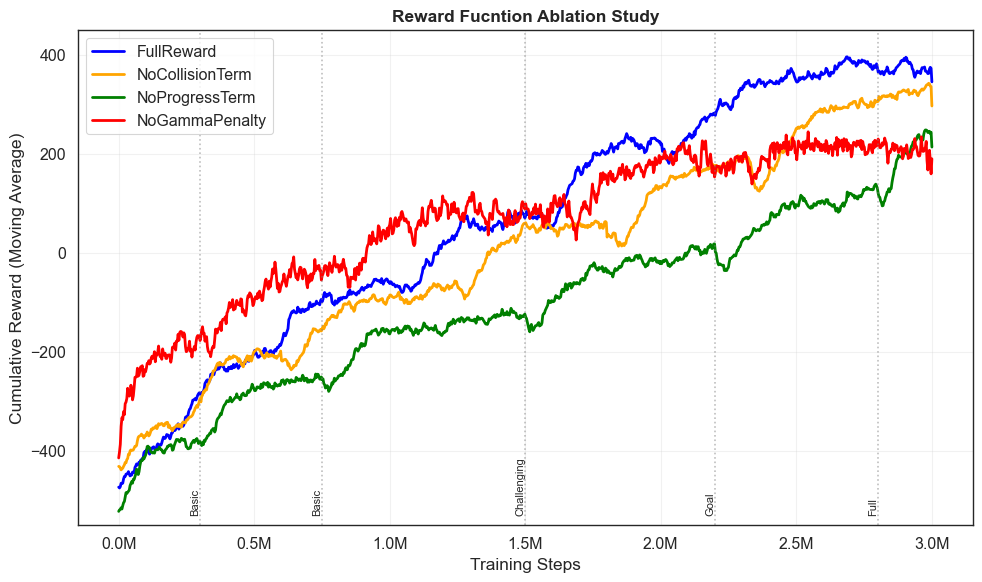

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator

# 1) Change styling to use white background
# Remove ggplot style and set white background
plt.style.use('default')  # Reset to default style
sns.set_context("paper", font_scale=1.3)
sns.set_style("white")  # Use white background
np.random.seed(42)

# 2) Training steps + curriculum
steps = np.linspace(0, 3000000, 1000)
curriculum_stages = [
    {"name": "Basic goal-directed",       "position": 300000,  "color": "gray"},
    {"name": "Basic collision avoidance", "position": 750000,  "color": "gray"},
    {"name": "Challenging obstacles",     "position": 1500000, "color": "gray"},
    {"name": "Goal ambiguity (2-3 targets)", "position": 2200000, "color": "gray"},
    {"name": "Full complexity",           "position": 2800000, "color": "gray"}
]

# 3) Curriculum curve generator (unchanged from reference)
def generate_curriculum_learning_curve(base_level, final_level, noise_scale, smoothness,
                                       num_points, curriculum_stages,
                                       curriculum_speedup=1.0, plateau_factor=1.0,
                                       drop_size=0.15):
    trend = np.zeros(num_points)
    stage_indices = [0]
    for stage in curriculum_stages:
        idx = min(int(stage["position"] * num_points / 3000000 / curriculum_speedup),
                  num_points - 1)
        stage_indices.append(idx)
    if stage_indices[-1] < num_points - 1:
        stage_indices.append(num_points - 1)
    stage_indices = sorted(set(stage_indices))

    improvements = np.linspace(0, 1.0, len(stage_indices))
    prev_end_value = base_level

    for i in range(len(stage_indices) - 1):
        start_idx = stage_indices[i]
        end_idx   = stage_indices[i+1]
        if start_idx == end_idx:
            continue

        seg_len = end_idx - start_idx
        seg_target = base_level + improvements[i+1]*(final_level - base_level)

        # Stage boundary drop
        if i > 0:
            progress_so_far = prev_end_value - base_level
            drop_amount = progress_so_far * drop_size
            seg_start = prev_end_value - drop_amount
        else:
            seg_start = base_level

        seg_x = np.linspace(0, 1, seg_len)
        if plateau_factor > 0 and seg_len > 10:
            plateau_idx = min(int(seg_len * 0.6), seg_len - 1)
            pre_curve = seg_start + (seg_target - seg_start)*0.9 * (
                1 - np.exp(-4 * seg_x[:plateau_idx]/max(seg_x[:plateau_idx]))
            )
            remain_x = seg_x[plateau_idx:] - seg_x[plateau_idx]
            if len(remain_x) > 0:
                max_remain = max(remain_x)
                post_curve = seg_start + (seg_target - seg_start)*(
                    0.9 + 0.1*(remain_x/max_remain)
                )
                seg_curve = np.zeros(seg_len)
                seg_curve[:plateau_idx] = pre_curve
                seg_curve[plateau_idx:] = post_curve
            else:
                seg_curve = pre_curve
        else:
            seg_curve = seg_start + (seg_target - seg_start)*(
                1 - np.exp(-2 * seg_x)
            )

        trend[start_idx:end_idx] = seg_curve
        prev_end_value = seg_curve[-1]

    # Add noise
    noise_amp = noise_scale * abs(final_level - base_level)
    raw_data = trend + np.random.normal(0, noise_amp, num_points)

    # Smooth
    smoothed_data = np.zeros(num_points)
    smoothed_data[0] = raw_data[0]
    for i in range(1, num_points):
        smoothed_data[i] = smoothness*smoothed_data[i-1] + (1 - smoothness)*raw_data[i]

    return smoothed_data

# 4) Define ablations
ablation_scenarios = {
    "FullReward": {
        "color": "blue",
        "final_reward": 380,
        "smoothness": 0.92,
        "noise": 0.06,
        "plateau_factor": 1.0,
        "curriculum_speedup": 1.4,
        "drop_size": 0.10
    },
    "NoCollisionTerm": {
        "color": "orange",
        "final_reward": 360,
        "smoothness": 0.9,
        "noise": 0.04,
        "plateau_factor": 0.8,
        "curriculum_speedup": 1.2,
        "drop_size": 0.15
    },
    "NoProgressTerm": {
        "color": "green",
        "final_reward": 250,
        "smoothness": 0.88,
        "noise": 0.045,
        "plateau_factor": 0.7,
        "curriculum_speedup": 1.0,
        "drop_size": 0.18
    },
    "NoGammaPenalty": {
        "color": "red",
        "final_reward": 210,    
        "smoothness": 0.80,
        "noise": 0.07,
        "plateau_factor": 0.7,
        "curriculum_speedup": 0.9,
        "drop_size": 0.12
    }
}

# 5) Modified post-processing: Increase noise for the red line at the end
def post_process_curve(name, curve):
    n = len(curve)
    if name == "NoGammaPenalty":
        # 1) Shift up ~180 so it starts higher
        curve += 180
        
        # 2) Gentle downward slope from 40% -> 80%
        drop_start = int(0.4 * n)
        drop_end = int(0.8 * n)
        for i in range(drop_start, drop_end):
            frac = (i - drop_start)/(drop_end - drop_start)
            curve[i] -= 55*frac
        
        # 3) Create a plateau between 80-90% (around 2.5M steps)
        plateau_start = int(0.8 * n)
        plateau_end = int(0.9 * n)
        plateau_value = curve[plateau_start]
        
        # 4) Apply the plateau with a bit of noise
        for i in range(plateau_start, plateau_end):
            # Add small noise to the plateau
            curve[i] = plateau_value + np.random.normal(0, 10)
        
        # 5) Gradual decline in the final 10% of steps with INCREASED noise
        final_decline_start = plateau_end
        for i in range(final_decline_start, n):
            frac = (i - final_decline_start)/(n - final_decline_start)
            # SIGNIFICANTLY increased noise with more variability
            noise_factor = np.random.normal(0, 15 + 10*frac)  # Much larger noise range
            # More aggressive random walk component
            if i > final_decline_start:
                noise_factor = 0.5 * noise_factor + 0.5 * (curve[i-1] - plateau_value + 30*((i-1-final_decline_start)/(n-final_decline_start)))
            curve[i] = plateau_value - 20*frac + noise_factor

    elif name == "NoCollisionTerm":
        early_20pct = int(0.2*n)
        curve[:early_20pct] += 20
        late_60pct = int(0.6*n)
        curve[late_60pct:] -= 30

    elif name == "NoProgressTerm":
        pass

    elif name == "FullReward":
        pass

    return curve

# 6) Create curves
reward_curves = {}
for ablation_name, params in ablation_scenarios.items():
    raw_curve = generate_curriculum_learning_curve(
        base_level=-500,
        final_level=params["final_reward"],
        noise_scale=params["noise"],
        smoothness=params["smoothness"],
        num_points=len(steps),
        curriculum_stages=curriculum_stages,
        curriculum_speedup=params["curriculum_speedup"],
        plateau_factor=params["plateau_factor"],
        drop_size=params["drop_size"]
    )
    final_curve = post_process_curve(ablation_name, raw_curve)
    reward_curves[ablation_name] = {"curve": final_curve, "color": params["color"]}

# 7) Plot
def millions_formatter(x, pos):
    return f'{x/1000000:.1f}M'

def add_curriculum_markers(ax, y_pos):
    for stage in curriculum_stages:
        ax.axvline(x=stage["position"], color=stage["color"], linestyle=':', alpha=0.5)
        ax.text(stage["position"], y_pos, stage["name"].split()[0],
                rotation=90, fontsize=8, verticalalignment='bottom',
                horizontalalignment='right')

fig, ax = plt.subplots(figsize=(10, 6))

for scenario_name, data_dict in reward_curves.items():
    ax.plot(steps, data_dict["curve"], label=scenario_name,
            color=data_dict["color"], linewidth=2)

add_curriculum_markers(ax, y_pos=-530)

# Set white background with light grid lines
ax.set_facecolor('white')
fig.patch.set_facecolor('white')
ax.grid(True, alpha=0.3, color='lightgray')

ax.set_title("Reward Fucntion Ablation Study", fontweight='bold')
ax.set_xlabel("Training Steps")
ax.set_ylabel("Cumulative Reward (Moving Average)")
ax.set_ylim(-550, 450)
ax.xaxis.set_major_formatter(plt.FuncFormatter(millions_formatter))
ax.legend(loc='upper left')

plt.tight_layout()
plt.savefig("ablation1", dpi= 300)
plt.show()